In [ ]:
import sys
sys.path.append('../..')
from lcs import SRC_ROOT

In [93]:
%matplotlib widget
import os
os.environ['ENABLE_PJRT_COMPATIBILITY'] = '1'
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
from lcs.configs import *
from lcs.joint_learning import *
import numpy as np
from lcs import TEXTWIDTH, PAGEHEIGHT
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from lcs.plotting_utils import *

In [94]:
logger = logging.getLogger('lcs')
logger.setLevel(logging.INFO)

g = 100  # hardness of switch

output_size = 2

cfgs = [Config(**dict(cfg_full_,
                num_paths=4,
                log_aux=False,
                t_tot=25,
                num_seeds=1,
                regularization_strength=0.6,
                 regularization_type=[
                    ("nonnegative", 1),
                    ("gating_manifold_L1", 10.0),
                    ("L2_W", reg_W),
                ],
                )) for reg_W in (0, 20.)]

In [95]:
tape = run_config(cfgs[0])
tape_reg = run_config(cfgs[1],)

[INFO] [2024-10-30 10:32:03,708] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=20,
       output_size=10,
       num_seeds=1,
       num_contexts=2,
       num_paths=4,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.6,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='full',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=None,
       W_teachers='generate',
       use_X=True,
       metric='cosine',
       teacher_mode='orthogonal',
       teacher_xx=0.0,
       teacher_scale='d_in',
       teacher_rotate=True,
       t_tot=25,
       T_tot=25000,
       num_blocks=26,
       block_duration=1.0,
 

/Users/jan/learning-context-sensing/.venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:6217: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/jan/learning-context-sensing/.venv/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:6218: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/Users/jan/learning-context-sensing/.venv/lib/python3.10/site-packages/jax/_src/nump

[WARNING] [2024-10-30 10:32:07,343] in lcs.joint_learning: grad norm c1 x lr is too large at 0.363770455121994, not operating in Gradient Flow regime. Consider reducing dt=0.001000. 
[INFO] [2024-10-30 10:32:07,465] in lcs.joint_learning: Running 1 seeds on device TFRT_CPU_0 with config Config(input_size=20,
       output_size=10,
       num_seeds=1,
       num_contexts=2,
       num_paths=4,
       batch_size=200,
       initialization_scale=0.01,
       gate_second=True,
       turn_off_regularization=False,
       regularization_strength=0.6,
       num_layers=1,
       hidden_size=10,
       context_model=True,
       name='full',
       regularization_type=[('nonnegative', 1),
                            ('gating_manifold_L1', 10.0),
                            ('L2_W', 20.0)],
       shared_teachers=False,
       shared_concat_teachers=False,
       c_gt_curriculum='A_B__',
       Y_tgt=None,
       W_teachers='generate',
       use_X=True,
       metric='cosine',
       teacher_

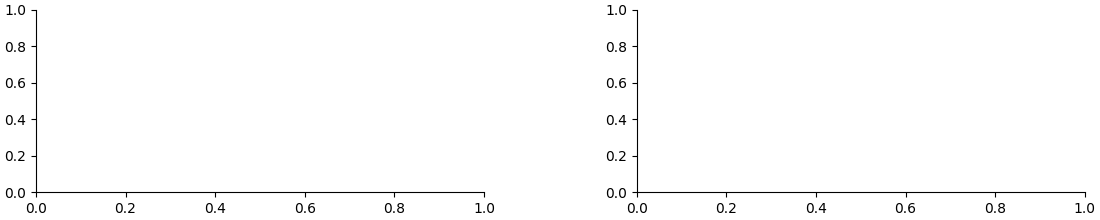

In [96]:
s = 2
fig = plt.figure(figsize=(s*TEXTWIDTH, s*PAGEHEIGHT*0.1), layout='constrained')

mosaic = """
ab
"""

axd = fig.subplot_mosaic(mosaic, gridspec_kw={'wspace': 0.2, })

ax_c = axd['a']
ax_c_reg = axd['b']

plt.show()

In [97]:
def sort_tape_c(tape):
    # resort gates for visualization
    tape = jax.tree.map(lambda x: x[0], tape)

    ti_task_1 = np.where(tape.c_gt1 == 0)[0]
    ti_task_2 = np.where(tape.c_gt1 == 1)[0]

    i_p1 = np.argmax(tape.c1[ti_task_1][-1000:], axis=-1)
    i_p2 = np.argmax(tape.c1[ti_task_2][-1000:], axis=-1)

    from scipy.stats import mode
    i_p1 = mode(i_p1)[0]
    i_p2 = mode(i_p2)[0]
    i_p3, i_p4 = list({0, 1, 2, 3} - {i_p1, i_p2})
    i_sort = [i_p1, i_p2, i_p3, i_p4]
    return eqx.tree_at(lambda t: t.c1, tape, tape.c1[:, i_sort])


In [98]:
ax = ax_c
ax.cla()
tape, cfg = tape, cfgs[0]
plot_c(ax, sort_tape_c(tape), cfg,)
ax.dataLim.y0 = 0
ax.dataLim.y1 = 1.5
ax.relim()
ax.autoscale_view()


In [99]:
ax = ax_c_reg
ax.cla()
tape, cfg = tape_reg, cfgs[1]

plot_c(ax, sort_tape_c(tape), cfg,)
ax.dataLim.y0 = 0
ax.dataLim.y1 = 1.5
ax.relim()
ax.autoscale_view()

In [100]:
setup_axes_labels(axd, labels=[k.upper() if k not in ['s'] else '' for k in axd.keys() ])

for k, ax in axd.items():
    ax.set_xlim(0, tape.t.max())
    indicate_contexts(ax, tape, cfg)
    make_ticks(ax, cfg, skip=50, minor=False)
    if k.lower() not in ['c', 'f']:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('time $t$')
   
fig.align_labels()

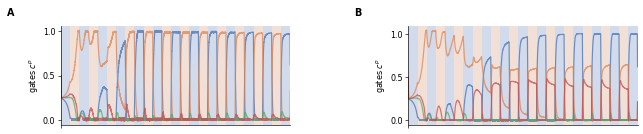

In [101]:
fig